In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../data/WS_2000_4_03.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../data/WS_2000_4_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

random.seed(256)
np.random.seed(256)    #指定生成“特定”的随机数

# 5. 阈值信息
batas = [0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, \
         0.21, 0.22, 0.23, 0.24, 0.25, 0.25, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40]
i_beta_21_1 = np.zeros([len(batas)])

In [5]:
time_start_outter = time.time()

for b in range(len(batas)):
    bata = batas[b]
    
    # 0. 公共参数
    Monte_Carlo_loop = 100    # 蒙特卡洛模拟次数
    time_steps = 100    # 总时间步数
    N = network_scale_1[0]    # 网络节点数

    # 1. SIS参数
    # bata = 0.2    # 感染概率
    mu = 0.4    # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    alert = 1
    inalert = 1 - alert

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4    # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触
    
    
    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]    # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)    # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)    # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 1))[0]    # 警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)    # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
#         awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
#         alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
#     awareness_count_average = np.mean(awareness_count, axis=0)
#     alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
#     assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
#     assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"
    
    i_beta = infective_count_average/N
    i_beta_21_1[b] = i_beta[99]
    
    print("loop_b {} - time has passed: {} ".format(b, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 75.73394346237183 
    loop_MC 1 - time has passed: 155.87625646591187 
    loop_MC 2 - time has passed: 234.76771807670593 
    loop_MC 3 - time has passed: 314.97154808044434 
    loop_MC 4 - time has passed: 395.52543807029724 
    loop_MC 5 - time has passed: 476.17629075050354 
    loop_MC 6 - time has passed: 555.5228850841522 
    loop_MC 7 - time has passed: 635.2605125904083 
    loop_MC 8 - time has passed: 715.2678039073944 
    loop_MC 9 - time has passed: 792.6703145503998 
    loop_MC 10 - time has passed: 872.4370458126068 
    loop_MC 11 - time has passed: 952.2104716300964 
    loop_MC 12 - time has passed: 1008.9567959308624 
    loop_MC 13 - time has passed: 1089.1442198753357 
    loop_MC 14 - time has passed: 1170.558099746704 
    loop_MC 15 - time has passed: 1249.9488048553467 
    loop_MC 16 - time has passed: 1330.327885389328 
    loop_MC 17 - time has passed: 1410.5199093818665 
    loop_MC 18 - time has passed: 1465.85473179

    loop_MC 53 - time has passed: 4158.633939504623 
    loop_MC 54 - time has passed: 4237.4542915821075 
    loop_MC 55 - time has passed: 4316.67097401619 
    loop_MC 56 - time has passed: 4394.839363574982 
    loop_MC 57 - time has passed: 4473.8851199150085 
    loop_MC 58 - time has passed: 4552.605836629868 
    loop_MC 59 - time has passed: 4631.067839860916 
    loop_MC 60 - time has passed: 4704.193572759628 
    loop_MC 61 - time has passed: 4783.530344009399 
    loop_MC 62 - time has passed: 4860.493817567825 
    loop_MC 63 - time has passed: 4938.856341838837 
    loop_MC 64 - time has passed: 5018.394129753113 
    loop_MC 65 - time has passed: 5074.327934026718 
    loop_MC 66 - time has passed: 5154.900393486023 
    loop_MC 67 - time has passed: 5231.8217515945435 
    loop_MC 68 - time has passed: 5310.720510959625 
    loop_MC 69 - time has passed: 5389.61825466156 
    loop_MC 70 - time has passed: 5468.873041152954 
    loop_MC 71 - time has passed: 5547.317197

    loop_MC 6 - time has passed: 526.4945333003998 
    loop_MC 7 - time has passed: 603.510758638382 
    loop_MC 8 - time has passed: 683.4374706745148 
    loop_MC 9 - time has passed: 760.4052290916443 
    loop_MC 10 - time has passed: 837.5520105361938 
    loop_MC 11 - time has passed: 916.0782651901245 
    loop_MC 12 - time has passed: 993.7475259304047 
    loop_MC 13 - time has passed: 1073.4998681545258 
    loop_MC 14 - time has passed: 1129.457444190979 
    loop_MC 15 - time has passed: 1207.563155889511 
    loop_MC 16 - time has passed: 1287.521611213684 
    loop_MC 17 - time has passed: 1366.6443252563477 
    loop_MC 18 - time has passed: 1446.4620869159698 
    loop_MC 19 - time has passed: 1525.0434284210205 
    loop_MC 20 - time has passed: 1602.7213740348816 
    loop_MC 21 - time has passed: 1658.6757626533508 
    loop_MC 22 - time has passed: 1738.5575518608093 
    loop_MC 23 - time has passed: 1818.2679028511047 
    loop_MC 24 - time has passed: 1897.7121

    loop_MC 59 - time has passed: 4546.788156747818 
    loop_MC 60 - time has passed: 4625.102598667145 
    loop_MC 61 - time has passed: 4702.942111492157 
    loop_MC 62 - time has passed: 4781.851808547974 
    loop_MC 63 - time has passed: 4860.816361427307 
    loop_MC 64 - time has passed: 4939.194207191467 
    loop_MC 65 - time has passed: 4994.737123966217 
    loop_MC 66 - time has passed: 5073.5222380161285 
    loop_MC 67 - time has passed: 5151.356226205826 
    loop_MC 68 - time has passed: 5230.235646486282 
    loop_MC 69 - time has passed: 5309.363359212875 
    loop_MC 70 - time has passed: 5388.787748098373 
    loop_MC 71 - time has passed: 5466.1907477378845 
    loop_MC 72 - time has passed: 5544.441543340683 
    loop_MC 73 - time has passed: 5622.059488296509 
    loop_MC 74 - time has passed: 5701.101896524429 
    loop_MC 75 - time has passed: 5778.975367069244 
    loop_MC 76 - time has passed: 5858.225190639496 
    loop_MC 77 - time has passed: 5938.92050

    loop_MC 12 - time has passed: 1015.4875497817993 
    loop_MC 13 - time has passed: 1092.8617672920227 
    loop_MC 14 - time has passed: 1172.3227608203888 
    loop_MC 15 - time has passed: 1249.651338338852 
    loop_MC 16 - time has passed: 1329.6081147193909 
    loop_MC 17 - time has passed: 1386.5553188323975 
    loop_MC 18 - time has passed: 1465.8052186965942 
    loop_MC 19 - time has passed: 1545.8577835559845 
    loop_MC 20 - time has passed: 1624.6487655639648 
    loop_MC 21 - time has passed: 1702.836419582367 
    loop_MC 22 - time has passed: 1784.2978415489197 
    loop_MC 23 - time has passed: 1863.4514167308807 
    loop_MC 24 - time has passed: 1942.9556772708893 
    loop_MC 25 - time has passed: 2022.2031602859497 
    loop_MC 26 - time has passed: 2103.1748304367065 
    loop_MC 27 - time has passed: 2158.6809051036835 
    loop_MC 28 - time has passed: 2234.9508550167084 
    loop_MC 29 - time has passed: 2314.3744966983795 
    loop_MC 30 - time has pass

    loop_MC 65 - time has passed: 5094.2791957855225 
    loop_MC 66 - time has passed: 5148.925643920898 
    loop_MC 67 - time has passed: 5228.266171216965 
    loop_MC 68 - time has passed: 5308.83620762825 
    loop_MC 69 - time has passed: 5388.506169319153 
    loop_MC 70 - time has passed: 5467.860417127609 
    loop_MC 71 - time has passed: 5546.083240270615 
    loop_MC 72 - time has passed: 5623.273857116699 
    loop_MC 73 - time has passed: 5702.379626274109 
    loop_MC 74 - time has passed: 5781.999885320663 
    loop_MC 75 - time has passed: 5861.0583300590515 
    loop_MC 76 - time has passed: 5939.568782329559 
    loop_MC 77 - time has passed: 6018.775967597961 
    loop_MC 78 - time has passed: 6098.2022342681885 
    loop_MC 79 - time has passed: 6175.547281503677 
    loop_MC 80 - time has passed: 6254.3819172382355 
    loop_MC 81 - time has passed: 6332.1872136592865 
    loop_MC 82 - time has passed: 6411.388047218323 
    loop_MC 83 - time has passed: 6490.598

    loop_MC 18 - time has passed: 1469.1192982196808 
    loop_MC 19 - time has passed: 1546.7140846252441 
    loop_MC 20 - time has passed: 1625.857038974762 
    loop_MC 21 - time has passed: 1703.6231417655945 
    loop_MC 22 - time has passed: 1782.4354810714722 
    loop_MC 23 - time has passed: 1859.578153371811 
    loop_MC 24 - time has passed: 1937.8414058685303 
    loop_MC 25 - time has passed: 2016.6460247039795 
    loop_MC 26 - time has passed: 2096.1777279376984 
    loop_MC 27 - time has passed: 2176.0773479938507 
    loop_MC 28 - time has passed: 2254.967462539673 
    loop_MC 29 - time has passed: 2335.3679044246674 
    loop_MC 30 - time has passed: 2414.8015360832214 
    loop_MC 31 - time has passed: 2491.8361992836 
    loop_MC 32 - time has passed: 2571.244336605072 
    loop_MC 33 - time has passed: 2649.15292263031 
    loop_MC 34 - time has passed: 2728.323552131653 
    loop_MC 35 - time has passed: 2806.372595310211 
    loop_MC 36 - time has passed: 2861.

    loop_MC 72 - time has passed: 5485.767149209976 
    loop_MC 73 - time has passed: 5564.979052066803 
    loop_MC 74 - time has passed: 5645.289682149887 
    loop_MC 75 - time has passed: 5722.290625572205 
    loop_MC 76 - time has passed: 5800.186997175217 
    loop_MC 77 - time has passed: 5876.801071405411 
    loop_MC 78 - time has passed: 5954.415868282318 
    loop_MC 79 - time has passed: 6032.310977935791 
    loop_MC 80 - time has passed: 6108.851012945175 
    loop_MC 81 - time has passed: 6185.402448654175 
    loop_MC 82 - time has passed: 6264.524497747421 
    loop_MC 83 - time has passed: 6341.45934677124 
    loop_MC 84 - time has passed: 6420.357799530029 
    loop_MC 85 - time has passed: 6500.536978006363 
    loop_MC 86 - time has passed: 6578.434323549271 
    loop_MC 87 - time has passed: 6656.897481918335 
    loop_MC 88 - time has passed: 6735.212038516998 
    loop_MC 89 - time has passed: 6814.549694299698 
    loop_MC 90 - time has passed: 6895.04888296

    loop_MC 25 - time has passed: 1885.6276149749756 
    loop_MC 26 - time has passed: 1965.151391029358 
    loop_MC 27 - time has passed: 2039.1087658405304 
    loop_MC 28 - time has passed: 2119.2702543735504 
    loop_MC 29 - time has passed: 2195.058730840683 
    loop_MC 30 - time has passed: 2268.3437898159027 
    loop_MC 31 - time has passed: 2346.8122894763947 
    loop_MC 32 - time has passed: 2422.3794071674347 
    loop_MC 33 - time has passed: 2496.6593265533447 
    loop_MC 34 - time has passed: 2572.7954456806183 
    loop_MC 35 - time has passed: 2647.572652578354 
    loop_MC 36 - time has passed: 2726.2781085968018 
    loop_MC 37 - time has passed: 2802.1136767864227 
    loop_MC 38 - time has passed: 2877.216905117035 
    loop_MC 39 - time has passed: 2932.656608581543 
    loop_MC 40 - time has passed: 3011.095851421356 
    loop_MC 41 - time has passed: 3084.785205602646 
    loop_MC 42 - time has passed: 3159.018774032593 
    loop_MC 43 - time has passed: 32

    loop_MC 79 - time has passed: 5903.936602115631 
    loop_MC 80 - time has passed: 5983.449939727783 
    loop_MC 81 - time has passed: 6056.670918941498 
    loop_MC 82 - time has passed: 6130.5476768016815 
    loop_MC 83 - time has passed: 6204.655335664749 
    loop_MC 84 - time has passed: 6284.359486103058 
    loop_MC 85 - time has passed: 6356.358203887939 
    loop_MC 86 - time has passed: 6432.701664924622 
    loop_MC 87 - time has passed: 6505.535828590393 
    loop_MC 88 - time has passed: 6578.655556440353 
    loop_MC 89 - time has passed: 6658.551579236984 
    loop_MC 90 - time has passed: 6732.795729875565 
    loop_MC 91 - time has passed: 6812.96396279335 
    loop_MC 92 - time has passed: 6892.405025005341 
    loop_MC 93 - time has passed: 6970.016216993332 
    loop_MC 94 - time has passed: 7042.311079263687 
    loop_MC 95 - time has passed: 7121.469720125198 
    loop_MC 96 - time has passed: 7199.04550409317 
    loop_MC 97 - time has passed: 7271.57854604

    loop_MC 32 - time has passed: 2401.7835614681244 
    loop_MC 33 - time has passed: 2473.1825761795044 
    loop_MC 34 - time has passed: 2545.485624074936 
    loop_MC 35 - time has passed: 2625.1591427326202 
    loop_MC 36 - time has passed: 2696.8408517837524 
    loop_MC 37 - time has passed: 2766.687624692917 
    loop_MC 38 - time has passed: 2837.812480688095 
    loop_MC 39 - time has passed: 2916.28844666481 
    loop_MC 40 - time has passed: 2995.3435785770416 
    loop_MC 41 - time has passed: 3067.3495659828186 
    loop_MC 42 - time has passed: 3145.321399450302 
    loop_MC 43 - time has passed: 3217.407707452774 
    loop_MC 44 - time has passed: 3296.39621257782 
    loop_MC 45 - time has passed: 3375.047134399414 
    loop_MC 46 - time has passed: 3445.859840631485 
    loop_MC 47 - time has passed: 3517.128425359726 
    loop_MC 48 - time has passed: 3589.09418964386 
    loop_MC 49 - time has passed: 3666.3143043518066 
    loop_MC 50 - time has passed: 3737.490

    loop_MC 85 - time has passed: 6163.136908531189 
    loop_MC 86 - time has passed: 6235.7125079631805 
    loop_MC 87 - time has passed: 6308.338580369949 
    loop_MC 88 - time has passed: 6379.0387971401215 
    loop_MC 89 - time has passed: 6451.2013466358185 
    loop_MC 90 - time has passed: 6521.917909860611 
    loop_MC 91 - time has passed: 6592.6327023506165 
    loop_MC 92 - time has passed: 6665.74427318573 
    loop_MC 93 - time has passed: 6737.133643865585 
    loop_MC 94 - time has passed: 6816.245671987534 
    loop_MC 95 - time has passed: 6894.963030576706 
    loop_MC 96 - time has passed: 6964.853457212448 
    loop_MC 97 - time has passed: 7038.008596420288 
    loop_MC 98 - time has passed: 7116.36746430397 
    loop_MC 99 - time has passed: 7189.170587062836 
loop_b 16 - time has passed: 127821.15309262276 
    loop_MC 0 - time has passed: 69.32245755195618 
    loop_MC 1 - time has passed: 138.38700032234192 
    loop_MC 2 - time has passed: 217.212592601776

    loop_MC 38 - time has passed: 2732.858154773712 
    loop_MC 39 - time has passed: 2788.4017963409424 
    loop_MC 40 - time has passed: 2856.201789855957 
    loop_MC 41 - time has passed: 2911.889096736908 
    loop_MC 42 - time has passed: 2991.179065465927 
    loop_MC 43 - time has passed: 3059.9979293346405 
    loop_MC 44 - time has passed: 3139.2539172172546 
    loop_MC 45 - time has passed: 3193.4325630664825 
    loop_MC 46 - time has passed: 3271.18226146698 
    loop_MC 47 - time has passed: 3340.3693387508392 
    loop_MC 48 - time has passed: 3409.7196798324585 
    loop_MC 49 - time has passed: 3478.1558878421783 
    loop_MC 50 - time has passed: 3546.2633163928986 
    loop_MC 51 - time has passed: 3614.8916857242584 
    loop_MC 52 - time has passed: 3683.096206665039 
    loop_MC 53 - time has passed: 3750.857006549835 
    loop_MC 54 - time has passed: 3827.482945203781 
    loop_MC 55 - time has passed: 3895.3934819698334 
    loop_MC 56 - time has passed: 396

    loop_MC 92 - time has passed: 6456.923687458038 
    loop_MC 93 - time has passed: 6524.2003927230835 
    loop_MC 94 - time has passed: 6579.923741817474 
    loop_MC 95 - time has passed: 6659.146471738815 
    loop_MC 96 - time has passed: 6726.717497825623 
    loop_MC 97 - time has passed: 6805.223928451538 
    loop_MC 98 - time has passed: 6871.9509489536285 
    loop_MC 99 - time has passed: 6939.404221057892 
loop_b 19 - time has passed: 148820.3185722828 
    loop_MC 0 - time has passed: 79.17632555961609 
    loop_MC 1 - time has passed: 146.17316555976868 
    loop_MC 2 - time has passed: 228.6606388092041 
    loop_MC 3 - time has passed: 297.33039689064026 
    loop_MC 4 - time has passed: 362.86621713638306 
    loop_MC 5 - time has passed: 441.73582100868225 
    loop_MC 6 - time has passed: 507.4239037036896 
    loop_MC 7 - time has passed: 584.5623710155487 
    loop_MC 8 - time has passed: 651.1908450126648 
    loop_MC 9 - time has passed: 717.7692015171051 
  

    loop_MC 45 - time has passed: 3077.8751401901245 
    loop_MC 46 - time has passed: 3142.9755725860596 
    loop_MC 47 - time has passed: 3209.1203558444977 
    loop_MC 48 - time has passed: 3276.323392391205 
    loop_MC 49 - time has passed: 3342.6470890045166 
    loop_MC 50 - time has passed: 3407.7903192043304 
    loop_MC 51 - time has passed: 3473.780523300171 
    loop_MC 52 - time has passed: 3552.418809890747 
    loop_MC 53 - time has passed: 3617.739564180374 
    loop_MC 54 - time has passed: 3684.163283586502 
    loop_MC 55 - time has passed: 3750.6541962623596 
    loop_MC 56 - time has passed: 3816.167197227478 
    loop_MC 57 - time has passed: 3881.6388697624207 
    loop_MC 58 - time has passed: 3947.5177981853485 
    loop_MC 59 - time has passed: 4013.159604072571 
    loop_MC 60 - time has passed: 4079.395094871521 
    loop_MC 61 - time has passed: 4145.617629528046 
    loop_MC 62 - time has passed: 4210.443247795105 
    loop_MC 63 - time has passed: 4276

    loop_MC 99 - time has passed: 6710.0483322143555 
loop_b 22 - time has passed: 169078.72424197197 
    loop_MC 0 - time has passed: 79.39315485954285 
    loop_MC 1 - time has passed: 143.76866960525513 
    loop_MC 2 - time has passed: 208.93077182769775 
    loop_MC 3 - time has passed: 274.9561517238617 
    loop_MC 4 - time has passed: 340.3859519958496 
    loop_MC 5 - time has passed: 419.45675683021545 
    loop_MC 6 - time has passed: 484.30217814445496 
    loop_MC 7 - time has passed: 549.6562919616699 
    loop_MC 8 - time has passed: 613.848869562149 
    loop_MC 9 - time has passed: 678.4742894172668 
    loop_MC 10 - time has passed: 742.5965805053711 
    loop_MC 11 - time has passed: 808.2217631340027 
    loop_MC 12 - time has passed: 873.3701617717743 
    loop_MC 13 - time has passed: 938.0360097885132 
    loop_MC 14 - time has passed: 1002.820611000061 
    loop_MC 15 - time has passed: 1068.1749057769775 
    loop_MC 16 - time has passed: 1133.003620147705 
  

    loop_MC 52 - time has passed: 3436.6369116306305 
    loop_MC 53 - time has passed: 3499.8860759735107 
    loop_MC 54 - time has passed: 3555.0885441303253 
    loop_MC 55 - time has passed: 3619.216356277466 
    loop_MC 56 - time has passed: 3674.13570022583 
    loop_MC 57 - time has passed: 3738.1720328330994 
    loop_MC 58 - time has passed: 3801.8853855133057 
    loop_MC 59 - time has passed: 3856.481369495392 
    loop_MC 60 - time has passed: 3919.907575368881 
    loop_MC 61 - time has passed: 3984.0784780979156 
    loop_MC 62 - time has passed: 4047.7293384075165 
    loop_MC 63 - time has passed: 4112.558211565018 
    loop_MC 64 - time has passed: 4190.705279350281 
    loop_MC 65 - time has passed: 4255.003447532654 
    loop_MC 66 - time has passed: 4318.319647312164 
    loop_MC 67 - time has passed: 4383.202868461609 
    loop_MC 68 - time has passed: 4446.697301387787 
    loop_MC 69 - time has passed: 4509.88547706604 
    loop_MC 70 - time has passed: 4573.79

    loop_MC 5 - time has passed: 392.05225682258606 
    loop_MC 6 - time has passed: 454.73826336860657 
    loop_MC 7 - time has passed: 531.7626221179962 
    loop_MC 8 - time has passed: 594.3946084976196 
    loop_MC 9 - time has passed: 657.2087755203247 
    loop_MC 10 - time has passed: 720.4810476303101 
    loop_MC 11 - time has passed: 799.2531430721283 
    loop_MC 12 - time has passed: 862.0665497779846 
    loop_MC 13 - time has passed: 924.9727690219879 
    loop_MC 14 - time has passed: 988.0038397312164 
    loop_MC 15 - time has passed: 1068.253692150116 
    loop_MC 16 - time has passed: 1134.9444026947021 
    loop_MC 17 - time has passed: 1203.321917295456 
    loop_MC 18 - time has passed: 1287.1281020641327 
    loop_MC 19 - time has passed: 1342.1630973815918 
    loop_MC 20 - time has passed: 1405.2477140426636 
    loop_MC 21 - time has passed: 1468.443954706192 
    loop_MC 22 - time has passed: 1530.9289526939392 
    loop_MC 23 - time has passed: 1593.84768

    loop_MC 58 - time has passed: 3799.035535812378 
    loop_MC 59 - time has passed: 3861.775762796402 
    loop_MC 60 - time has passed: 3923.763374567032 
    loop_MC 61 - time has passed: 3986.847643136978 
    loop_MC 62 - time has passed: 4066.695242881775 
    loop_MC 63 - time has passed: 4145.068922758102 
    loop_MC 64 - time has passed: 4207.6939532756805 
    loop_MC 65 - time has passed: 4270.019426822662 
    loop_MC 66 - time has passed: 4332.191180944443 
    loop_MC 67 - time has passed: 4395.727477073669 
    loop_MC 68 - time has passed: 4474.349566936493 
    loop_MC 69 - time has passed: 4537.173518657684 
    loop_MC 70 - time has passed: 4601.178019285202 
    loop_MC 71 - time has passed: 4663.667453527451 
    loop_MC 72 - time has passed: 4726.031847715378 
    loop_MC 73 - time has passed: 4804.255661010742 
    loop_MC 74 - time has passed: 4866.603091716766 
    loop_MC 75 - time has passed: 4929.384234428406 
    loop_MC 76 - time has passed: 4991.173732

    loop_MC 11 - time has passed: 745.8750212192535 
    loop_MC 12 - time has passed: 806.800793170929 
    loop_MC 13 - time has passed: 869.0414974689484 
    loop_MC 14 - time has passed: 929.7895109653473 
    loop_MC 15 - time has passed: 991.3127982616425 
    loop_MC 16 - time has passed: 1052.488537788391 
    loop_MC 17 - time has passed: 1130.6854884624481 
    loop_MC 18 - time has passed: 1192.2981371879578 
    loop_MC 19 - time has passed: 1254.4737882614136 
    loop_MC 20 - time has passed: 1316.2806487083435 
    loop_MC 21 - time has passed: 1394.1253607273102 
    loop_MC 22 - time has passed: 1455.6601648330688 
    loop_MC 23 - time has passed: 1517.5009002685547 
    loop_MC 24 - time has passed: 1578.9637806415558 
    loop_MC 25 - time has passed: 1641.1391668319702 
    loop_MC 26 - time has passed: 1702.6728990077972 
    loop_MC 27 - time has passed: 1764.7035269737244 
    loop_MC 28 - time has passed: 1819.779206752777 
    loop_MC 29 - time has passed: 18

    loop_MC 64 - time has passed: 4064.3807950019836 
    loop_MC 65 - time has passed: 4125.8199689388275 
    loop_MC 66 - time has passed: 4187.1752462387085 
    loop_MC 67 - time has passed: 4249.022776842117 
    loop_MC 68 - time has passed: 4313.8202340602875 
    loop_MC 69 - time has passed: 4399.573688745499 
    loop_MC 70 - time has passed: 4465.161620616913 
    loop_MC 71 - time has passed: 4527.189053058624 
    loop_MC 72 - time has passed: 4588.965685844421 
    loop_MC 73 - time has passed: 4650.437969684601 
    loop_MC 74 - time has passed: 4711.9256319999695 
    loop_MC 75 - time has passed: 4773.588607311249 
    loop_MC 76 - time has passed: 4828.881797075272 
    loop_MC 77 - time has passed: 4890.86551451683 
    loop_MC 78 - time has passed: 4952.490388393402 
    loop_MC 79 - time has passed: 5013.878748178482 
    loop_MC 80 - time has passed: 5075.560456752777 
    loop_MC 81 - time has passed: 5135.744020462036 
    loop_MC 82 - time has passed: 5196.370

In [6]:
print(i_beta_21_1)

[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 2.35000e-04
 1.14500e-03 5.02000e-03 1.49150e-02 5.54850e-02 7.04500e-02 1.33525e-01
 1.41740e-01 2.07785e-01 2.15160e-01 2.36050e-01 2.53785e-01 2.81770e-01
 3.08155e-01 3.19460e-01 3.68020e-01 3.68095e-01 4.17865e-01 4.22335e-01
 4.26780e-01 4.20080e-01 4.05270e-01 4.33350e-01 4.78325e-01 4.81235e-01
 4.81365e-01]


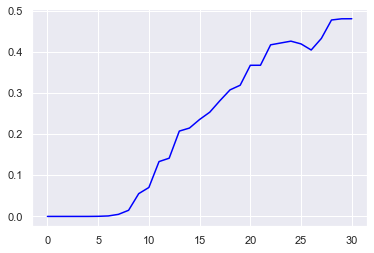

In [7]:
plt.plot(i_beta_21_1, color='blue')

In [8]:
scio.savemat('./i_beta_21_1.mat', {'i_beta_21_1': i_beta_21_1})